In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import seaborn as sns
from scipy.ndimage import rotate, zoom
from matplotlib.patches import Rectangle

In [7]:
# Get image numbers from train_images/authentic
authentic_path = "data/train_images/authentic"
authentic_files = glob.glob(os.path.join(authentic_path, "*.png"))
authentic_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in authentic_files]))

# Get image numbers from train_images/forged
forged_path = "data/train_images/forged"
forged_files = glob.glob(os.path.join(forged_path, "*.png"))
forged_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in forged_files]))

# Get image numbers from supplemental_images
supplemental_path = "data/supplemental_images"
supplemental_files = glob.glob(os.path.join(supplemental_path, "*.png"))
supplemental_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in supplemental_files]))

# Get train masks
train_masks_path = "data/train_masks"
train_masks = glob.glob(os.path.join(train_masks_path, "*.npy"))

# Get supplemental masks
supplemental_masks_path = "data/supplemental_masks"
supplemental_masks = glob.glob(os.path.join(supplemental_masks_path, "*.npy"))

print(f"Authentic images: {len(authentic_nums)}")
print(f"Forged images: {len(forged_nums)}")
print(f"Supplemental images: {len(supplemental_nums)}")

Authentic images: 2377
Forged images: 2751
Supplemental images: 48


In [99]:
def resize_and_pad_image(img: Image.Image, target=512):
    """
    Rotate so longest side is horizontal, resize longest side to target,
    then pad shorter side to target. Works for RGB/Grayscale images.
    """
    # Convert to RGB if needed
    if img.mode not in ["RGB", "RGBA", "L"]:
        img = img.convert("RGB")

    w, h = img.size

    # Rotate if height > width (tall image)
    if h > w:
        img = img.rotate(90, expand=True)
        w, h = img.size

    # Scale long side to target=512
    scale = target / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    img = img.resize((new_w, new_h), Image.BILINEAR)

    # Pad to 512 x 512
    pad_w = (target - new_w) // 2
    pad_h = (target - new_h) // 2

    # Create padded canvas (black)
    new_img = Image.new(img.mode, (target, target))
    new_img.paste(img, (pad_w, pad_h))

    return new_img

In [100]:
def resize_and_pad_mask(mask: np.ndarray, target=512):
    """
    Rotate so long side is horizontal, resize longest side to target,
    then pad shorter side to target. Uses nearest-neighbor interpolation.
    mask: H x W (or H x W x C label array)
    """
    h, w = mask.shape[:2]

    # Rotate if height > width
    if h > w:
        # rotate 90 degrees CCW; nearest interpolation
        mask = rotate(mask, 90, reshape=True, order=0)
        h, w = mask.shape[:2]

    # Scale long side
    scale = target / max(w, h)
    zoom_factors = (scale, scale) + ((1,) if mask.ndim == 3 else ())
    mask = zoom(mask, zoom_factors, order=0)

    new_h, new_w = mask.shape[:2]

    # Create padded 512x512 mask
    padded = np.zeros((target, target) + (() if mask.ndim == 2 else (mask.shape[2],)),
                      dtype=mask.dtype)

    pad_h = (target - new_h) // 2
    pad_w = (target - new_w) // 2

    padded[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = mask

    return padded

In [101]:
def get_bounding_boxes_with_margin(mask, margin=1):
    """
    Find the smallest bounding boxes that surround all connected components in a mask,
    with an added margin around each box.
    
    Args:
        mask: Binary mask array (2D numpy array with 1s and 0s)
        margin: Margin to add around each bounding box (default: 1)
    
    Returns:
        Array of bounding boxes, each as [min_row, min_col, max_row, max_col]
        Returns empty array if no components found
    """
    # Ensure mask is binary
    mask_bin = (mask > 0).astype(np.uint8)
    
    # Find connected components (islands of 1s)
    labeled_mask, num_features = ndimage.label(mask_bin)
    
    if num_features == 0:
        return np.array([]).reshape(0, 4)
    
    # Get bounding boxes for each component efficiently
    # find_objects returns a list of slice objects, one per component
    slices = ndimage.find_objects(labeled_mask)
    
    boxes = []
    H, W = mask_bin.shape
    
    for slice_obj in slices:
        if slice_obj is None:
            continue
            
        row_slice, col_slice = slice_obj
        
        # Get bounding box coordinates
        min_row = row_slice.start
        max_row = row_slice.stop - 1  # stop is exclusive, so subtract 1
        min_col = col_slice.start
        max_col = col_slice.stop - 1
        
        # Add margin, clamping to image boundaries
        min_row = max(0, min_row - margin)
        min_col = max(0, min_col - margin)
        max_row = min(H - 1, max_row + margin)
        max_col = min(W - 1, max_col + margin)
        
        boxes.append([min_row, min_col, max_row, max_col])
    
    return np.array(boxes)


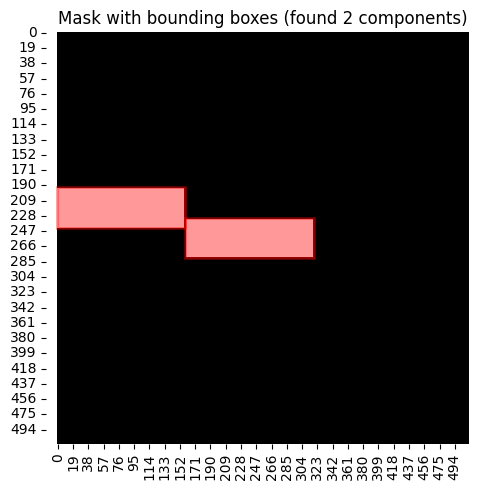

In [147]:
# Plot bounding box over masks

mask_choice = np.random.choice(train_masks)
mask = resize_and_pad_mask(np.load(mask_choice)[0])

# Get bounding boxes
boxes = get_bounding_boxes_with_margin(mask)

# Plot mask
plt.figure(figsize=(5, 5))
sns.heatmap(mask, cmap='gray', cbar=False)

# Plot each bounding box with alpha=0.4

for box in boxes:
    min_row, min_col, max_row, max_col = box
    
    # Draw rectangle
    width = max_col - min_col + 1
    height = max_row - min_row + 1
    
    rect = Rectangle((min_col, min_row), width, height, 
                     linewidth=2, edgecolor='red', facecolor='red', alpha=0.4)
    plt.gca().add_patch(rect)

plt.title(f'Mask with bounding boxes (found {len(boxes)} components)')
plt.axis('equal')
plt.tight_layout()
plt.show()